I entered [this](https://www.kaggle.com/c/pkdd-15-predict-taxi-service-trajectory-i/) Kaggle competition several months ago but did not take the time to write up my approach and how I did until now. I was fairly pleased with my performance on this challenge after placing 30/381 on the public leaderboard and finishing at 76/381 on the private one. In a [previous post](/data-science-and-kaggle.html) I mentioned that "if your model is accurate enough to be useful then you're on the right track" and I stand by that statement. In this case I think being able to predict a taxi's final destination to within ~50 meters qualifies as useful, although I suppose that depends on your usecase.

In [1]:
import json
import os.path
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from mpl_toolkits.basemap import Basemap
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [2]:
train_df = pd.read_csv('./data/train.csv')
train_df.head()

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA,POLYLINE
0,1372636858620000589,C,NaN,NaN,20000589,1372636858,A,False,"[[-8.618643,41.141412],[-8.618499,41.141376],[..."
1,1372637303620000596,B,NaN,7,20000596,1372637303,A,False,"[[-8.639847,41.159826],[-8.640351,41.159871],[..."
2,1372636951620000320,C,NaN,NaN,20000320,1372636951,A,False,"[[-8.612964,41.140359],[-8.613378,41.14035],[-..."
3,1372636854620000520,C,NaN,NaN,20000520,1372636854,A,False,"[[-8.574678,41.151951],[-8.574705,41.151942],[..."
4,1372637091620000337,C,NaN,NaN,20000337,1372637091,A,False,"[[-8.645994,41.18049],[-8.645949,41.180517],[-..."


After reading the training data set into a dataframe, the next step is to do some feature engineering. Before we take a look at the main feature engineering function, let's take a look at several helper functions used within it.

In [3]:
def process_chunk(df):
    df.drop(df[df['MISSING_DATA'] == True].index, inplace=True)
    call_map = {'A': 1, 'B': 2, 'C': 3}
    df['CALL_TYPE'] = df['CALL_TYPE'].map(call_map)
    df['TIMESTAMP'] = pd.to_datetime(df['TIMESTAMP'], unit='s')
    df['DATE'] = df['TIMESTAMP'].dt.date.map(dt.date.toordinal)
    df['YEAR'] = df['TIMESTAMP'].dt.year
    df['MONTH'] = df['TIMESTAMP'].dt.month
    df['WEEK'] = df['TIMESTAMP'].dt.week
    df['DAY'] = df['TIMESTAMP'].dt.day
    df['HOUR'] = df['TIMESTAMP'].dt.hour
    df['MINUTE'] = df['TIMESTAMP'].dt.minute
    df['MINUTEOFDAY'] = df['HOUR'] * 60 + df['MINUTE']
    df['SECOND'] = df['TIMESTAMP'].dt.second
    df['SECONDOFDAY'] = df['MINUTEOFDAY'] * 60 + df['SECOND']
    df['WEEKDAY'] = df['TIMESTAMP'].dt.weekday
    df['POLYLINE'] = df['POLYLINE'].map(json.loads)
    df['POLYLINE'] = df['POLYLINE'].map(np.array)
    df['KNOWN_DURATION'] = df['POLYLINE'].map(len) * 15

    return df

The `process_chunk` function is the first step in our pipeline - here we do some basic data cleansing by dropping any rows which have been labelled by the provider as missing data and coverting fields from their input strings into more useful formats. We also extract several date and time metrics from the timestamp as well as calculate the total duration of the trip.

In [4]:
EARTH_RADIUS = 6371


def haversine(start_lon, start_lat, end_lon, end_lat):
    start_lon = np.radians(start_lon)
    start_lat = np.radians(start_lat)
    end_lon = np.radians(end_lon)
    end_lat = np.radians(end_lat)

    dlon = end_lon - start_lon
    dlat = end_lat - start_lat

    a = (np.sin(dlat / 2)**2 + np.cos(start_lat) * np.cos(end_lat) *
         np.sin(dlon / 2)**2)
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    return np.nan_to_num(c * EARTH_RADIUS)


def bearing(start_lon, start_lat, end_lon, end_lat):
    start_lon = np.radians(start_lon)
    start_lat = np.radians(start_lat)
    end_lon = np.radians(end_lon)
    end_lat = np.radians(end_lat)

    dlon = end_lon - start_lon
    x = np.sin(dlon) * np.cos(end_lat)
    y = (np.cos(start_lat) * np.sin(end_lat) -
         (np.sin(start_lat) * np.cos(end_lat) * np.cos(dlon)))

    initial_bearing = np.arctan2(x, y)

    initial_bearing = np.degrees(initial_bearing)
    compass_bearing = (initial_bearing + 360) % 360

    return np.nan_to_num(compass_bearing)

The next set of functions take two points and calculate the distance travelled between those points as well as the direction of travel. The `haveresine` function is a vectorized implementation of the [Haversine formula](https://en.wikipedia.org/wiki/Haversine_formula). The Haversine formula gives us the distance between two points on sphere and for the purpose of this challenge we are choosing to assume that the earth is a perfect sphere.

The `bearing` function calculates the angle between the start and end points in degrees. Like the `haversine` function has been vectorized in order to improve its efficiency.

In [5]:
def remove_outliers(df, column):
    summary = df[column].describe(percentiles=[0.01, 0.99])
    return df[(df[column] >= summary['1%']) & (df[column] <= summary['99%'])]

`remove_outliers` is a simple function to eliminate any rows in the top and bottom 1% of observed values. 

In [6]:
def add_closest_station(df):
    lookup_df = pd.read_csv(
        './data/metaData_taxistandsID_name_GPSlocation.csv')
    lookup_df = lookup_df.reindex(
        lookup_df['ID']).drop(['ID', 'Descricao'], axis=1).dropna()

    merged_df = pd.DataFrame(
        np.array(
            pd.tools.util.cartesian_product([df.index, lookup_df.index])).T,
        columns=['DF_INDEX', 'LOOKUP_INDEX'])
    merged_df = merged_df.merge(df[['ORIGIN_LON', 'ORIGIN_LAT']],
                                left_on='DF_INDEX',
                                right_index=True).merge(lookup_df,
                                                        left_on='LOOKUP_INDEX',
                                                        right_index=True)
    merged_df['DISTANCE'] = haversine(merged_df['ORIGIN_LON'],
                                      merged_df['ORIGIN_LAT'],
                                      merged_df['Longitude'],
                                      merged_df['Latitude'])

    closest_df = merged_df[
        (merged_df.groupby('DF_INDEX')['DISTANCE'].transform(np.min) ==
            merged_df['DISTANCE'])]
    closest_df = closest_df.drop_duplicates(['DF_INDEX', 'DISTANCE'])
    closest_df.index = closest_df['DF_INDEX']
    df['CLOSEST_ID'] = closest_df['LOOKUP_INDEX']
    df['CLOSEST_DISTANCE'] = closest_df['DISTANCE']
    df['CLOSEST_LON'] = closest_df['Longitude']
    df['CLOSEST_LAT'] = closest_df['Latitude']

    return df

The `add_closest_station` function uses the provided lookup table to determine which taxi stands were located closest to the point of origin. 

In [7]:
def process_df(df, train=True):
    df = process_chunk(df)

    if train:
        df.drop(df[df['KNOWN_DURATION'] < 30].index, inplace=True)

    df['ORIGIN'] = df['POLYLINE'].map(lambda x: x[0])
    df['ORIGIN_LON'] = df['ORIGIN'].map(lambda x: x[0])
    df['ORIGIN_LAT'] = df['ORIGIN'].map(lambda x: x[1])
    df['ORIGIN_CALL'].fillna(0, inplace=True)
    df['ORIGIN_STAND'].fillna(0, inplace=True)

    if train:
        df['DEST'] = df['POLYLINE'].map(lambda x: x[-1])
        df['DEST_LON'] = df['DEST'].map(lambda x: x[0])
        df['DEST_LAT'] = df['DEST'].map(lambda x: x[1])
        df['POLYLINE'] = df['POLYLINE'].map(lambda x: x[:-1])
        df['KNOWN_DURATION'] = df['KNOWN_DURATION'] - 15
        df.drop(['DEST'], axis=1, inplace=True)
        for column in ['ORIGIN_LON', 'ORIGIN_LAT', 'DEST_LON', 'DEST_LAT']:
            df = remove_outliers(df, column)

    df['LAST_LOC'] = df['POLYLINE'].map(lambda x: x[-1])
    df['LAST_LON'] = df['LAST_LOC'].map(lambda x: x[0])
    df['LAST_LAT'] = df['LAST_LOC'].map(lambda x: x[1])

    df['KNOWN_DISTANCE'] = haversine(df['ORIGIN_LON'].values,
                                     df['ORIGIN_LAT'].values,
                                     df['LAST_LON'].values,
                                     df['LAST_LAT'].values)
    df['KNOWN_BEARING'] = bearing(df['ORIGIN_LON'].values,
                                  df['ORIGIN_LAT'].values,
                                  df['LAST_LON'].values,
                                  df['LAST_LAT'].values)

    df = add_closest_station(df)

    df.drop(['DAY_TYPE',
             'MISSING_DATA',
             'ORIGIN',
             'LAST_LOC',
             'POLYLINE',
             'TIMESTAMP'], axis=1, inplace=True)

    return df

Now in the `process_df` function we combine all of the above helper functions and return a brand new dataframe with all of the features we desire.

From the 'POLYLINE' field we can determine the origin location, last known destination and known duration of the trip. We use the same function to engineer features in our training set and in our test set but in our training set we must remove the final destination point as this is the target variable we are tying to predict. 

In [8]:
temp_df = None
for df in np.array_split(train_df, 8):
    if temp_df is None:
        temp_df = process_df(df)
    else:
        temp_df = temp_df.append(process_df(df), ignore_index=True)
train_df = temp_df
train_df.head()

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,DATE,YEAR,MONTH,WEEK,DAY,...,DEST_LON,DEST_LAT,LAST_LON,LAST_LAT,KNOWN_DISTANCE,KNOWN_BEARING,CLOSEST_ID,CLOSEST_DISTANCE,CLOSEST_LON,CLOSEST_LAT
0,1372636858620000589,3,0,0,20000589,735050,2013,7,27,1,...,-8.630838,41.154489,-8.630829,41.154498,1.777194,324.964954,33,0.246333,-8.615952,41.140517
1,1372637303620000596,2,0,7,20000596,735050,2013,7,27,1,...,-8.665740,41.170671,-8.665767,41.170635,2.480394,298.992343,58,0.149766,-8.641205,41.160703
2,1372636951620000320,3,0,0,20000320,735050,2013,7,27,1,...,-8.615970,41.140530,-8.617365,41.140863,0.372779,278.647868,52,0.128926,-8.614012,41.141208
3,1372636854620000520,3,0,0,20000520,735050,2013,7,27,1,...,-8.607996,41.142915,-8.608005,41.142915,2.965908,250.209078,7,0.544230,-8.568195,41.151592
4,1372637091620000337,3,0,0,20000337,735050,2013,7,27,1,...,-8.687268,41.178087,-8.687259,41.178078,3.463916,265.572875,61,0.294710,-8.646558,41.177874


In addition to looking at the table of data produced by `process_df` it is often useful to visualise your data. The `draw_map` function produces a heatmap of origins and destinations to help us get a feel for the data.

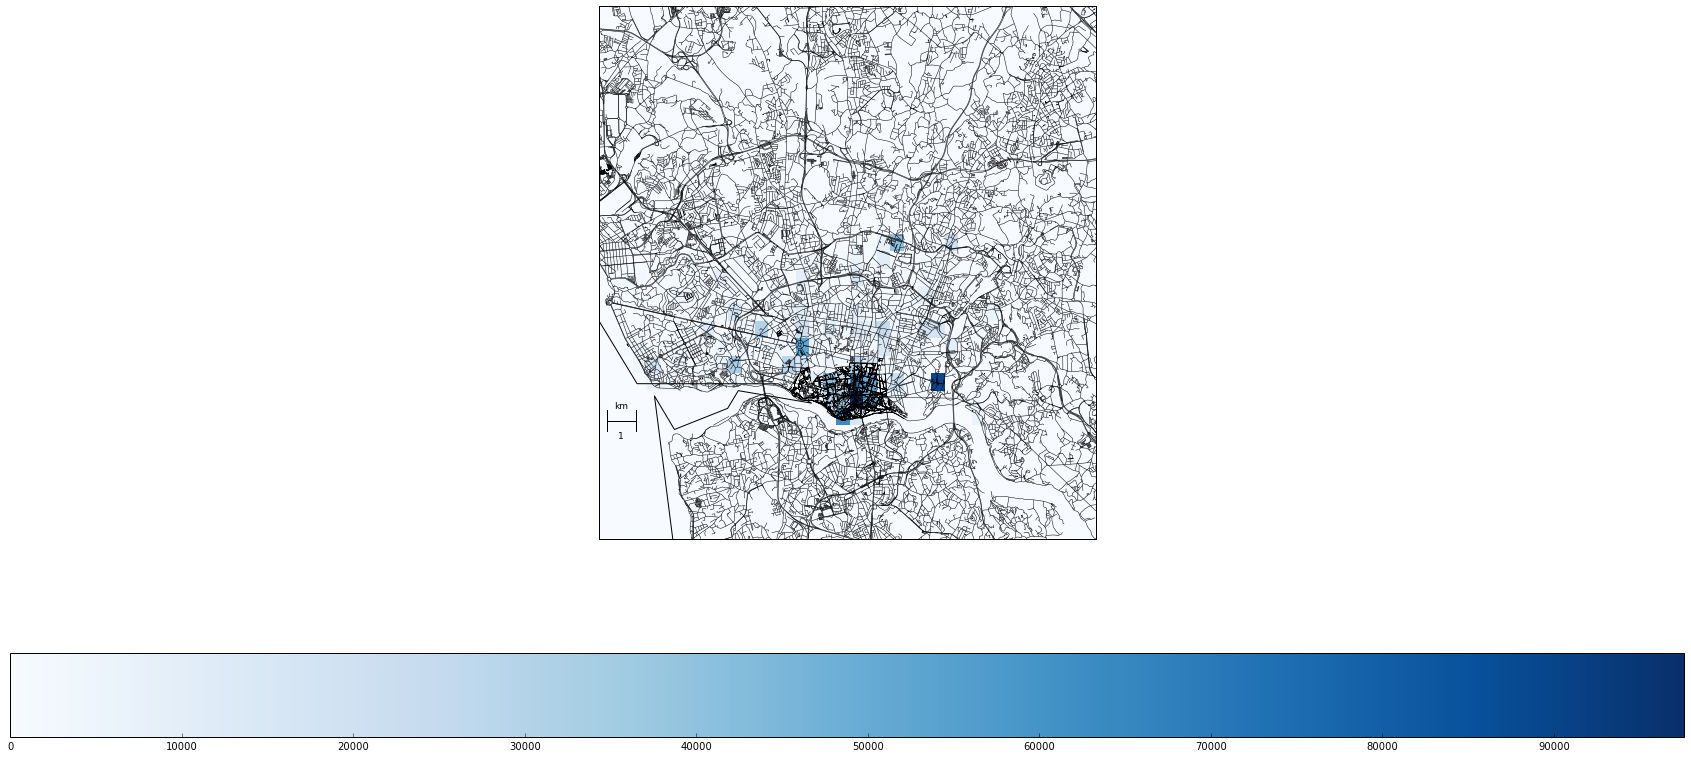

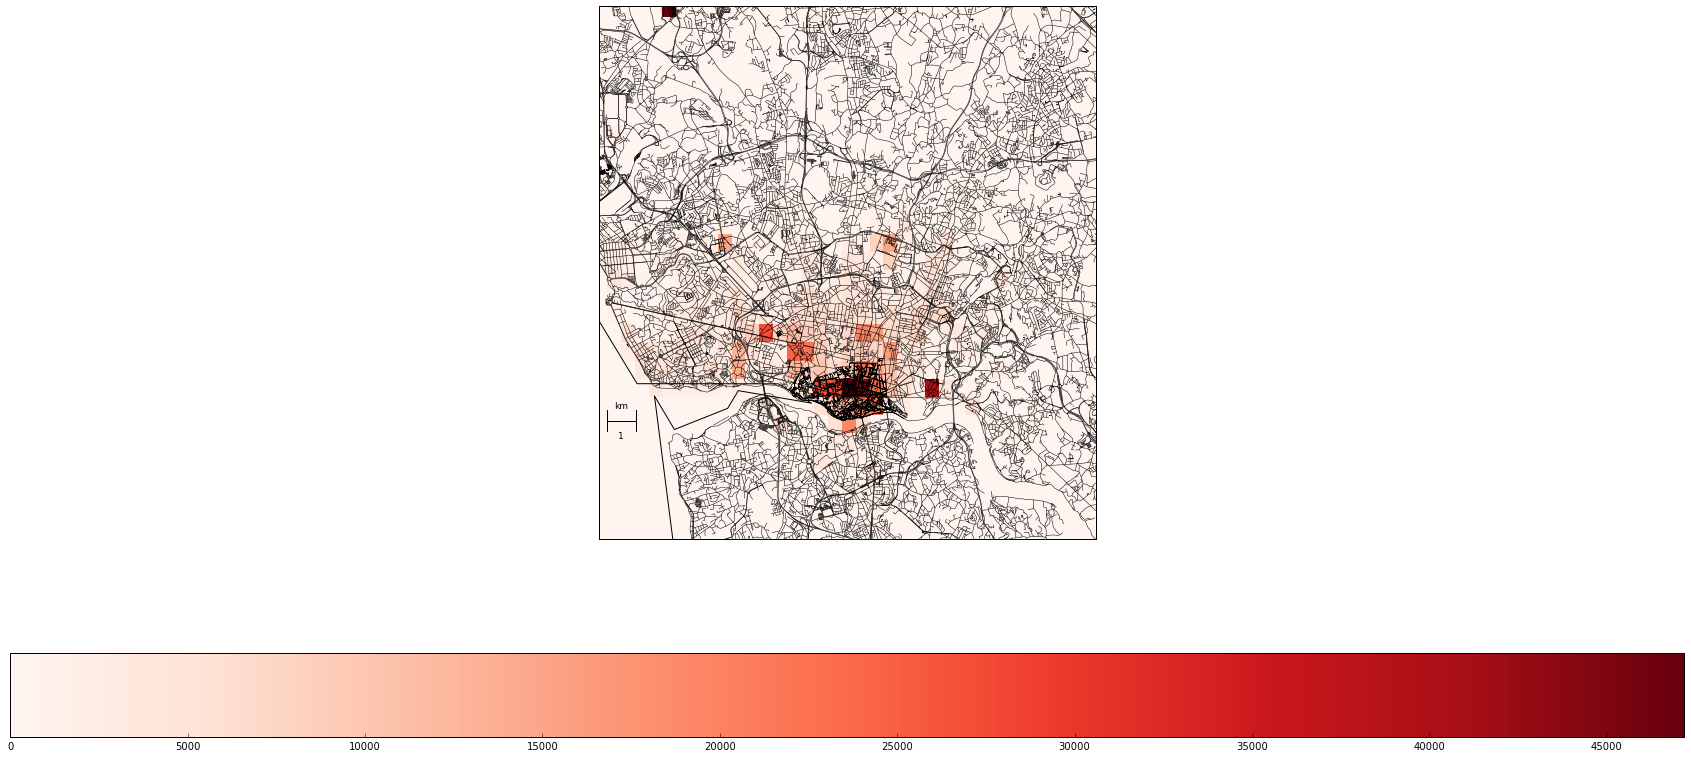

In [9]:
%matplotlib inline


def draw_map(lon_column, lat_column, subplot=1, cmap='Blues'):
    plt.figure(figsize=(30, 30))
    plt.subplot(2, 1, subplot)
    m = Basemap(projection='merc',
                resolution='h',
                urcrnrlon=-8.5363740000000004,
                urcrnrlat=41.237622000000002,
                llcrnrlon=-8.6920289999999998,
                llcrnrlat=41.112071999999998)
    # Portugal shapefile obtained from the OpenStreetMap project at
    # http://wiki.openstreetmap.org/wiki/Shapefiles
    m.readshapefile('./data/roads', 'landmarks')
    m.drawcoastlines()
    m.drawrivers()
    m.drawcountries()
    m.drawmapboundary()

    lon_bins = np.linspace(lon_column.min() - 1, lon_column.max() + 1, 500)
    lat_bins = np.linspace(lat_column.min() - 1, lat_column.max() + 1, 500)

    density, _, _ = np.histogram2d(lat_column,
                                   lon_column,
                                   [lat_bins, lon_bins])

    lon_bins_2d, lat_bins_2d = np.meshgrid(lon_bins, lat_bins)

    xs, ys = m(lon_bins_2d, lat_bins_2d)

    plt.pcolormesh(xs, ys, density, cmap=plt.get_cmap(cmap))
    plt.colorbar(orientation='horizontal')

    m.scatter(lon_column.tolist(),
              lat_column.tolist(),
              alpha=0.00125,
              latlon=True,
              c='green')

    m.drawmapscale(-8.685, 41.14, -8.685, 41.14, 1)

draw_map(train_df['ORIGIN_LON'], train_df['ORIGIN_LAT'])
draw_map(train_df['DEST_LON'], train_df['DEST_LAT'], 2, 'Reds')

The top chart shows the distribution of where taxis trips originate whereas the bottom chart demonstrates where they tend to end. Unsurprisingly, most trips begin and end in the city center; however, there appears to be a public transit center just East of the center which is a popular place to both start and end taxi trips. Looking it up on Google Maps, I believe that this corresponds to [Porto Campanhã](https://www.google.co.uk/maps/place/Porto+Campanh%C3%A3/@41.151155,-8.5846748,14.61z/data=!4m2!3m1!1s0x0d24649056fa051f:0x64904b60cf025b52) station. The distribution inferred from this graph is what inspired the logic used in the `clean_short_trips` function used later on in this analysis.

Now that the data has been processed we are now able to set up the components of our machine learning pipeline. The first step in the pipeline is a [feature scaling](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) followed by a variant on [random forests regression](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesRegressor.html). 

In [10]:
scaler = StandardScaler()
etr = ExtraTreesRegressor(n_estimators=100, n_jobs=-1)
pipe = Pipeline([('scaler', scaler), ('etr', etr)])

In [11]:
train_data = train_df.drop(['TRIP_ID', 'DEST_LON', 'DEST_LAT'], axis=1).values
target_data = np.array([train_df['DEST_LON'], train_df['DEST_LAT']]).T
train_data, cv_data, target_data, cv_target_data = train_test_split(
    train_data, target_data, test_size=0.2)
pipe.fit(train_data, target_data)

Pipeline(steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('etr', ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
          min_samples_split=2, min_weight_fraction_leaf=0.0,
          n_estimators=100, n_jobs=-1, oob_score=False, random_state=None,
          verbose=0, warm_start=False))])

In this step we split our training data into a training and cross validation set by randomly sampling 20% of the data and using that to assess the predictive quality of our model. 

In [12]:
cv_predictions = pipe.predict(cv_data)
results = haversine(cv_target_data[:, 0],
                    cv_target_data[:, 1],
                    cv_predictions[:, 0],
                    cv_predictions[:, 1])
print('Average estimate was {} km off.'.format(results.mean()))

Average estimate was 0.04710165313506486 km off.


Our model looks to be pretty good with an average estimate being ~47m off from the actual destination. Considering this is less than the length of an average city block, I would say the model is doing a pretty good job when tested against the cross validation set.  

In [13]:
def clean_short_trips(train_df, test_df):
    mid_lon = train_df['ORIGIN_LON'].mean()
    avg_short_distance = train_df.loc[train_df['KNOWN_DURATION'] == 30,
                                      'KNOWN_DISTANCE'].mean() / 2
    avg_short_bearing_left = train_df.loc[train_df['ORIGIN_LON'] < mid_lon,
                                          'KNOWN_BEARING'].mean()
    avg_short_bearing_right = train_df.loc[train_df['ORIGIN_LON'] >= mid_lon,
                                           'KNOWN_BEARING'].mean()

    test_df.loc[test_df['KNOWN_DURATION'] == 15,
                'KNOWN_DISTANCE'] = avg_short_distance
    test_df.loc[(test_df['KNOWN_DURATION'] == 15) &
                (test_df['ORIGIN_LON'] < mid_lon),
                'KNOWN_BEARING'] = avg_short_bearing_left
    test_df.loc[(test_df['KNOWN_DURATION'] == 15) &
                (test_df['ORIGIN_LON'] >= mid_lon),
                'KNOWN_BEARING'] = avg_short_bearing_right

    return test_df

The `clean_short_trips` function takes the average distance for trips with only two data points (30-44 second trips) and uses those figures to estimate the distance and bearing for trips which only have the starting point in the test set (15-29 second trips).

In [14]:
test_df = pd.read_csv('./data/test.csv')
test_df = process_df(test_df, False)
test_df = clean_short_trips(train_df, test_df)
test_data = test_df.drop(['TRIP_ID'], axis=1).values
predictions = pipe.predict(test_data)

with open('./data/output.csv', 'w') as o:
    o.write('TRIP_ID,LATITUDE,LONGITUDE\n')
    for trip_id, prediction in zip(test_df['TRIP_ID'], predictions):
        o.write('{},{},{}\n'.format(trip_id, prediction[1], prediction[0]))

From there, confident that our fitted model is somewhat accurate, we can then proceed to evaluating the test set and saving the results to a file which we can upload on the competition page to see how we do on the leaderboards. 

Considering this was one of my first forays into a Kaggle competition, I am pretty pleased with the results. For this competition I spent a fair amount of time trying out different algorithms in Scikit-learn and determining which ones were most effective; however, in the future it would be better to familiarise myself with the models and select the most appropriate one based on a better understanding of the fundamentals that underlie them.  